In [2]:
# 导入相关需求包
# 基础包
import os
import math
import numpy as np    #导入Python科学计算的基础软件包numpy
import pandas as pd     #导入python的一个数据分析包pandas
# 数据分析包
## 模型包
from sklearn import decomposition    #导入数据降维包decomposition，以便后面导入PCA包
from sklearn.ensemble import RandomForestClassifier  # 导入随机森林算法
from imblearn.ensemble import BalancedRandomForestClassifier # 导入平衡随机森林算法
## 模型相关包——数据预处理
from sklearn import preprocessing  # 导入数据预处理包
from sklearn.model_selection import train_test_split  # 导入训练集和测试集划分函数tain_test_split
from sklearn.preprocessing import StandardScaler  # 导入数据标准化函数
from imblearn.under_sampling import RandomUnderSampler # 欠抽样处理库RandomUnderSampler
## 模型相关包——导入模型训练相关优化函数
from sklearn.model_selection import StratifiedKFold     #导入将数据划分函数StratifiedKFold
from sklearn.model_selection import GridSearchCV    #导入网格搜索自动调参函数GridSearchCV
## 模型相关包——模型评估
from sklearn.metrics import *    #导入metrics模块的所有函数，metrics模块实现了一些函数，用来评估预测误差。已使用：precision_recall_curve
# 绘图包
import scikitplot as skplt # 绘制模型P-R曲线
import matplotlib.pyplot as plt    #导入Python可视化Matplotlib模块的绘图pyplot函数
import seaborn as sns    #导入Python数据可视化matplotlib模块扩展版seaborn模型

# 导入其他模型包
import xgboost as xgb

In [1]:
class tool_functions(object):
    # start_column_num, end_column_num are numbers of corresponding columns (1-based, start&end included)
    def columns_rename(column_names, start_column_num, end_column_num, suffix):
        # directly rename corresponding column names
        for i in range(start_column_num-2, end_column_num-1):
            column_names[i] = "_".join([suffix, str(i - start_column_num + 1)])
    # rename_info_dict is a dict whose key was suffix and values were other info
    def batch_columns_rename(column_names, rename_info_dict):
        for suffix in rename_info_dict.keys():
            start_column_num, end_column_num = rename_info_dict[suffix]
            # start_column_num, end_column_num are numbers of corresponding columns (1-based, start&end included)
            for i in range(start_column_num-2, end_column_num-1):
                column_names[i] = "_".join([suffix, str(i - start_column_num + 1)])
    # 检查不同信息对应大类中各个变量的value_counts分类情况
    def info_class_features_split_check(train_info, class_suffix):
        class_column_names = [col for col in train_info.columns if col.startswith(class_suffix)]
        print(f"训练数据共有{len(train_info)}行，其中以{class_suffix}为起始的列具体分布情况如下所示：")
        for single_class_column_name in class_column_names:
            single_value_counts_info = train_info[single_class_column_name].value_counts()
            print(f"{single_class_column_name}列对应值分类数目为{len(single_value_counts_info)}，有值的行数为{single_value_counts_info.sum()}")
    # 检查某特征在训练集、测试集中的分布情况是否一致，绘制分类柱状图
    def feature_train_test_class_plot(feature_name, train_info, test_info):
        train_info_tag, test_info_tag = train_info.copy(), test_info.copy()
        del train_info_tag['flag']
        train_info_tag['tag'] = "train"
        test_info_tag['tag'] = "test"
        train_test_info_tag = pd.concat([train_info_tag, test_info_tag], axis=0)
        sns.countplot(x=feature_name, hue='tag', data=train_test_info_tag)

In [71]:
class data_train_test_process(object):
    # 初始化类实例
    # train_info为输入的训练数据对应dataframe
    # test_info为输入的测试数据对应dataframe
    # test_label为输入的测试数据对应label
    def __init__(self, train_info, test_info, test_label):
        self.train_info = train_info
        self.test_info = test_info
        self.test_label = test_label

    # 输入：实例自带的train_info、test_info
    # 输出：实例修改的train_info，为重新构建列名后的训练数据
    # 输出2：实例修改的test_info，为重新构建列名后的测试数据
    def data_rename(self):
        # 对训练数据进行整理，重新构建列名
        old_columns = self.train_info.columns
        new_columns = list(self.train_info.columns)
        # start rename with index 6
        # index numbers below were excel-compatible (1-based)
        # * 8-14: number of accounts. 
        # * 15-35: transaction status. (16-19 **null** values detected)
        # * 36-48: asset status. 
        # * 49-58: loan status. (**all null** values detected)
        # * 59-166, 315-330: channel transaction status. (**all null** values detected, small portion to be zeros)
        # * 167-178: channel behavior. (**all null** values detected)
        # * 179-282: third-party transaction status. (**all null** values detected)
        # * 283-314: self-service device transaction status. (**all 0** values detected)
        # * 331-338: other signatures. (**all 0** values detected)
        rename_info_dict = {
            "accounts_num": [8, 14], 
            "transaction_status": [15, 35], 
            "asset_status": [36, 48], 
            "loan_status": [49, 58], 
            "channel_trans_status_a": [59, 166], 
            "channel_behavior": [167, 178], 
            "third_trans_status": [179, 282], 
            "self_service_trans_status": [283, 314], 
            "channel_trans_status_b": [315, 330], 
            "other_sigs": [331, 338]
        }
        tool_functions.batch_columns_rename(new_columns, rename_info_dict)
        self.train_info.columns = new_columns

        # 对测试数据进行整理，重新构建列名
        old_columns = self.test_info.columns
        new_columns = list(self.test_info.columns)
        ## test_info只是在train_info的基础上少了一列(flag)，再全部减1即可
        for key in rename_info_dict.keys():
            rename_info_dict[key] = [single_index - 1 for single_index in rename_info_dict[key]]
        tool_functions.batch_columns_rename(new_columns, rename_info_dict)
        self.test_info.columns = new_columns

    # 输入：实例修改的train_info
    # 输出：打印train_info各大类对应特征列的信息分布情况 + 结局变量分类情况
    def data_description(self):
        # 检查打印train_info相关情况记载
        print("训练数据中不同结局分布情况：")
        print(self.train_info["flag"].value_counts())
        # 检查打印各大类对应特征列的信息分布情况
        all_suffix_list = ['sex', 'marriage_satatus', 'age', 'occupation', 'educate', 
        'accounts_num', 'transaction_status', 'asset_status', 'loan_status', 
        'channel_trans_status_a', 'channel_trans_status_b', 'channel_behavior', 
        'third_trans_status', 'self_service_trans_status', 'other_sigs']
        for col_suffix in all_suffix_list: 
            tool_functions.info_class_features_split_check(self.train_info, col_suffix)

    # 输入：实例自带的train_info、test_info
    # 输出：实例修改的train_info、test_info，为经过数据探索后，针对性对各列数据信息重新赋值所得
    def data_special_treatment(self):
        # 对于sex列（性别具有排他性，仅保留占比最大的1、2，其他均赋值为0）
        self.train_info['sex'] = self.train_info.sex.map(lambda x: x if [1, 2].__contains__(x) else 0)
        self.test_info['sex'] = self.test_info.sex.map(lambda x: x if [1, 2].__contains__(x) else 0)
        # 对于marriage_satatus列（仅保留占比最大的-1、1、2、8，其他均赋值为0）
        self.train_info['marriage_satatus'] = self.train_info.marriage_satatus.map(lambda x: x if [-1, 1, 2, 8].__contains__(x) else 0)
        self.test_info['marriage_satatus'] = self.test_info.marriage_satatus.map(lambda x: x if [-1, 1, 2, 8].__contains__(x) else 0)
        # 对于age列（除服从正态分布且占比最大的1-116，其他均归赋值为0，因其占比异常大）
        self.train_info['age'] = self.train_info.age.map(lambda x: x if range(1, 117).__contains__(x) else 0)
        self.test_info['age'] = self.test_info.age.map(lambda x: x if range(1, 117).__contains__(x) else 0)
        # 注意暂不对occupation列进行修改
        # 对于occupation列（仅保留占比最大的-1-23，其他均归赋值为0，因其占比异常大）
        ## 获取occupation中占比少于1%的类，并将其重新赋值
        occupation_little_class = [class_name for class_name in self.train_info.occupation.value_counts().index if self.train_info.occupation.value_counts()[class_name] > len(self.train_info)*0.01]
        self.train_info['occupation'] = self.train_info.occupation.map(lambda x: x if occupation_little_class.__contains__(x) else 0)
        self.test_info['occupation'] = self.test_info.occupation.map(lambda x: x if occupation_little_class.__contains__(x) else 0)
        # 对于educate列（仅保留占比最大的-1、4、9，其他均归赋值为0，因其占比异常大）
        educate_little_class = [class_name for class_name in self.train_info.educate.value_counts().index if self.train_info.educate.value_counts()[class_name] > len(self.train_info)*0.01]
        self.train_info['educate'] = self.train_info.educate.map(lambda x: x if educate_little_class.__contains__(x) else 0)
        self.test_info['educate'] = self.test_info.educate.map(lambda x: x if educate_little_class.__contains__(x) else 0)

    # 输入：实例修改的train_info、test_info
    # 输出：实例修改的train_info、test_info
    def data_refinement(self):
        # 针对训练数据进行变量筛选
        
        # 排除掉缺失值过多的特征列（排除标准定为删除包含90%以上缺失值的特征列）
        print(f"开始删除缺失值过多的特征列（阈值为90%），删除前训练数据的特征列数为{len(self.train_info.columns)}")
        self.train_info = self.train_info.dropna(thresh=0.1*len(self.train_info), axis="columns")
        print(f"删除后训练数据的特征列数为{len(self.train_info.columns)}")
        ## test_info进而采用相同的特征列
        sub_col_list = list(self.train_info.columns)
        sub_col_list.remove("flag")
        self.test_info = self.test_info[sub_col_list]

        # 排除掉缺失值过多的特征行
        print(f"开始删除缺失值过多的特征行（阈值为80%），删除前训练数据行数为{len(self.train_info)}")
        self.train_info = self.train_info.dropna(thresh=0.2*len(self.train_info.columns), axis="index")
        print(f"删除后训练数据的特征行数为{len(self.train_info)}")

    # 输入：实例修改的train_info、test_info
    # 输出：实例新建的training_data、y，为添加分类信息对应哑变量后的训练数据、训练标签
    # 输出2：实例新建的test_data，为添加分类信息对应哑变量后的测试数据
    def data_preprocess(self):
        # 删除分类变量所对应列后的training_data + 构建训练标签y
        ## settime列为日期信息，无实意，删除
        self.training_data = self.train_info.drop(['flag', 'sex', 'marriage_satatus', 'occupation', 'educate', 'settime'], axis=1)
        self.y = self.train_info['flag']
        # 将相应列（必然为分类变量）转为one-hot变量，并纳入训练数据training_data中
        categorical_variable_list = ['sex', 'marriage_satatus', 'occupation', 'educate']
        categorical_variable_dataframe_list = []
        for categorical_variable in categorical_variable_list:
            categorical_variable_dataframe_list.append(pd.get_dummies(self.train_info[categorical_variable], prefix=categorical_variable))
        self.training_data = pd.concat([self.training_data] + categorical_variable_dataframe_list, axis=1)
    
        # 构建（整理）测试数据test_data
        self.test_data = self.test_info.drop(['sex', 'marriage_satatus', 'occupation', 'educate', 'settime'], axis=1)
        # 将相应列（必然为分类变量）转为one-hot变量，并纳入训练数据training_data中
        categorical_variable_list = ['sex', 'marriage_satatus', 'occupation', 'educate']
        categorical_variable_dataframe_list = []
        for categorical_variable in categorical_variable_list:
            categorical_variable_dataframe_list.append(pd.get_dummies(self.test_info[categorical_variable], prefix=categorical_variable))
        self.test_data = pd.concat([self.test_data] + categorical_variable_dataframe_list, axis=1)

    # 输入：实例新建的X_train、X_holdout、y_train、y_holdout，为实例的训练/测试数据集
    # 输出：经过网格搜索获取最佳参数所对应的xgboost模型xgb_gcv
    def model_training(self):
        # 开始构建xgboost训练模型
        from xgboost.sklearn import XGBClassifier
        # 从sklearn库中导入网格调参函数
        from sklearn.model_selection import GridSearchCV

        # 划分数据集便于进行交叉验证
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)  # 设置划分数据集的参数——5折交叉验证
        ## 目前最优参数组合
        learning_rate = [0.04]
        subsample = [0.9]
        colsample_bytree = [0.75]
        max_depth = [9]
        ## 定义参数取值范围
        # learning_rate = [0.01*i for i in range(1, 5)]
        # subsample = [i/10.0 for i in range(7,10)]
        # colsample_bytree = [0.75, 0.8, 0.85]
        # max_depth = [9]

        parameters = {'learning_rate': learning_rate,
                    'subsample': subsample,
                    'colsample_bytree': colsample_bytree,
                    'max_depth': max_depth}
        model = XGBClassifier(n_estimators=1000, random_state=17, tree_method="gpu_hist") # 似乎并没有调用gpu

        # 开始进行网格搜索
        print("开始进行网格搜索......")
        print("目标参数为：")
        print(parameters)
        self.xgb_gcv = GridSearchCV(model, parameters, cv=skf, scoring='f1', verbose=1, n_jobs=20) # 并行进行12个进程
        self.xgb_gcv.fit(self.training_data,self.y)
        print(self.xgb_gcv.best_params_)  ##网格搜索后的最优参数

        # 网格搜索结束
        print("\n网格搜索结束......")
        print("最优参数、训练数据得分(F1值)分别为：")
        print((self.xgb_gcv.best_params_, self.xgb_gcv.best_score_))

        # 模型初步评估
        self.xgb_pred = self.xgb_gcv.predict(self.test_data)  # 预测测试集的类别
        print("\n不调整阈值，对测试集的预测得分如下所示：")
        print("Accuracy Score : (how much of variants type was predicted correctly) :",
            accuracy_score(self.test_label, self.xgb_pred))  # 打印准确度
        print("Recall Score (how much of TP were predicted correctly) : ", recall_score(self.test_label, self.xgb_pred))  # 打印召回率
        print("Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'): ", precision_score(self.test_label, self.xgb_pred))  # 打印精度
    
    # 输入：经过网格搜索获取最佳参数所对应的xgboost模型xgb_gcv
    # 输入2：实例新建的test_data、test_label，为实例的测试数据集和label信息
    # 输出：实例新建的common_xgb_PR_thre、common_xgb_PR_thre_2，分别为通过F1值和PR曲线最高点所对应判别阈值
    def model_tuning(self):
        # 应用PR曲线进行优化
        print("\n应用PR曲线完成对xgboost梯度提升树的优化")
        # 首先检验测试集概率分布情况
        self.xgb_pred = self.xgb_gcv.predict_proba(self.test_data)  # 以概率形式预测测试集的类别
        plt.hist(self.xgb_pred[:, 1])
        # 绘制模型PR曲线，得到PR曲线所对应的最优界值（使F1最大的阈值，相对比较合理）
        skplt.metrics.plot_precision_recall_curve(self.test_label, self.xgb_pred)
        precisions, recalls, thresholds = precision_recall_curve(self.test_label, self.xgb_pred[:, 1])
        print("模型对应PR曲线下面积为", auc(recalls, precisions))
        optimal_idx = np.argmax((2 * precisions * recalls) / (precisions + recalls))
        self.common_xgb_PR_thre = thresholds[optimal_idx]
        print("PR曲线上使F1最大的阈值为：", self.common_xgb_PR_thre)

        # 找出距离(0,1)最近的阈值点（第二种思路）
        distance = pow((precisions - 1), 2) + pow((recalls - 1.0), 2)
        distance_sqrt = [math.sqrt(single_distance) for single_distance in distance]
        optimal_distance_idx = np.argmin(distance_sqrt)
        self.common_xgb_PR_thre_2 = thresholds[optimal_distance_idx]
        print("PR曲线上距离(0,1)最近的阈值为：", self.common_xgb_PR_thre_2)

        # 根据对应的不同阈值来评估相应效果
        print("\n应用PR曲线阈值一来完成测试集评估：")
        self.xgb_predicted = (self.xgb_pred[:, 1] >= self.common_xgb_PR_thre).astype('int')

        print("Accuracy Score : (how much of variants type was predicted correctly) :",
            accuracy_score(self.test_label, self.xgb_predicted))  # 打印准确度
        print("Recall Score (how much of TP were predicted correctly) : ",
            recall_score(self.test_label, self.xgb_predicted))  # 打印召回率
        print("F1 Score (composite metric for precision and recall): ",
            f1_score(self.test_label, self.xgb_predicted))  # 打印精度
        print("Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'): ",
            precision_score(self.test_label, self.xgb_predicted))  # 打印精度

        print("\n应用PR曲线阈值二来完成测试集评估：")
        self.xgb_predicted = (self.xgb_pred[:, 1] >= self.common_xgb_PR_thre_2).astype('int')

        print("Accuracy Score : (how much of variants type was predicted correctly) :",
            accuracy_score(self.test_label, self.xgb_predicted))  # 打印准确度
        print("Recall Score (how much of TP were predicted correctly) : ",
            recall_score(self.test_label, self.xgb_predicted))  # 打印召回率
        print("F1 Score (composite metric for precision and recall): ",
            f1_score(self.test_label, self.xgb_predicted))  # 打印精度
        print("Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'): ",
            precision_score(self.test_label, self.xgb_predicted))  # 打印精度
    
    # 应用目前效果最好的模型进行测试
    # 输入：经过网格搜索获取最佳参数所对应的xgboost模型xgb_gcv
    # 输入2：实例新建的test_data，为添加分类信息对应哑变量后的测试数据
    # 输出：实例新建的test_pred_PR_thre、test_pred_PR_thre_2，为独立测试数据集根据不同阈值所得到的预测结果
    # 输出2：实例新建的属性test_positive_PR_thre、test_positive_PR_thre_2，为独立测试数据集根据不同阈值所得到的阳性数据集（negative为阴性数据集）
    def model_utilze(self):
        # 数据概览
        # 检验测试集概率分布情况
        print("\n独立测试数据集概率分布情况如下所示：")
        test_pred = self.xgb_gcv.predict_proba(self.test_data)  # 概率形式预测测试集的类别
        plt.hist(test_pred[:, 1])

        print("测试数据集行数为%d" % (len(self.test_data)))
        # 数据预测
        # 根据PR曲线相应阈值一完成预测
        print("\n根据PR曲线相应阈值一(%f)完成预测"%(self.common_xgb_PR_thre))
        self.test_pred_PR_thre = (test_pred[:, 1] >= self.common_xgb_PR_thre).astype('int')
        # 获取预测阳性、阴性的结果，报告并导出
        self.test_positive_PR_thre = self.test_data[self.test_pred_PR_thre == 1]
        self.test_negative_PR_thre = self.test_data[self.test_pred_PR_thre == 0]
        print("总SNP数目为%d，其中通过模型判别为阳性的个案数目为%d，占比为1:%d" % (
        len(self.test_data), len(self.test_positive_PR_thre), len(self.test_data) / len(self.test_positive_PR_thre)))

        # 根据PR曲线相应阈值二完成预测
        print("\n根据PR曲线相应阈值二(%f)完成预测"%(self.common_xgb_PR_thre_2))
        self.test_pred_PR_thre_2 = (test_pred[:, 1] >= self.common_xgb_PR_thre_2).astype('int')
        # 获取预测阳性、阴性的结果，报告并导出
        self.test_positive_PR_thre_2 = self.test_data[self.test_pred_PR_thre_2 == 1]
        self.test_negative_PR_thre_2 = self.test_data[self.test_pred_PR_thre_2 == 0]
        print("总SNP数目为%d，其中通过模型判别为阳性的个案数目为%d，占比为1:%d" % (
            len(self.test_data), len(self.test_positive_PR_thre_2),
            len(self.test_data) / len(self.test_positive_PR_thre_2)))

In [72]:
train_info = pd.read_csv("/home/lqh/projects/程浩/广东省农信联社2021年校园挑战赛-数据集与数据说明-第一赛道/数据集+数据说明/train.csv", index_col="cust_id")
test_info = pd.read_csv("/home/lqh/projects/程浩/广东省农信联社2021年校园挑战赛-数据集与数据说明-第一赛道/数据集+数据说明/test.csv", index_col="cust_id")
test_label = pd.read_csv("/home/lqh/projects/程浩/广东省农信联社2021年校园挑战赛-数据集与数据说明-第一赛道/数据集+数据说明/test_label.csv")

In [73]:
data_analysis = data_train_test_process(train_info, test_info, test_label)

In [74]:
data_analysis.data_rename()

In [75]:
data_analysis.data_description()

训练数据中不同结局分布情况：
0    700000
1     84000
Name: flag, dtype: int64
训练数据共有784000行，其中以sex为起始的列具体分布情况如下所示：
sex列对应值分类数目为5，有值的行数为765219
训练数据共有784000行，其中以marriage_satatus为起始的列具体分布情况如下所示：
marriage_satatus列对应值分类数目为8，有值的行数为765219
训练数据共有784000行，其中以age为起始的列具体分布情况如下所示：
age列对应值分类数目为229，有值的行数为784000
训练数据共有784000行，其中以occupation为起始的列具体分布情况如下所示：
occupation列对应值分类数目为87，有值的行数为764632
训练数据共有784000行，其中以educate为起始的列具体分布情况如下所示：
educate列对应值分类数目为10，有值的行数为556386
训练数据共有784000行，其中以accounts_num为起始的列具体分布情况如下所示：
accounts_num_-1列对应值分类数目为171，有值的行数为760315
accounts_num_0列对应值分类数目为137，有值的行数为760315
accounts_num_1列对应值分类数目为116，有值的行数为760315
accounts_num_2列对应值分类数目为106，有值的行数为760315
accounts_num_3列对应值分类数目为108，有值的行数为760315
accounts_num_4列对应值分类数目为102，有值的行数为760315
accounts_num_5列对应值分类数目为614，有值的行数为760315
训练数据共有784000行，其中以transaction_status为起始的列具体分布情况如下所示：
transaction_status_-1列对应值分类数目为32，有值的行数为142885
transaction_status_0列对应值分类数目为46，有值的行数为142885
transaction_status_1列对应值分类数目为58，有值的行数为142885
transaction_status_2列对应值分类数目为87，有值的行数为142885
tran

In [76]:
data_analysis.data_special_treatment()

In [77]:
data_analysis.data_refinement()

开始删除缺失值过多的特征列（阈值为90%），删除前训练数据的特征列数为338
删除后训练数据的特征列数为288
开始删除缺失值过多的特征行（阈值为80%），删除前训练数据行数为784000
删除后训练数据的特征行数为760413


In [78]:
data_analysis.data_preprocess()

In [79]:
data_analysis.model_training()

开始进行网格搜索......
目标参数为：
{'learning_rate': [0.04], 'subsample': [0.9], 'colsample_bytree': [0.75], 'max_depth': [9]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed: 10.5min remaining: 15.8min
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed: 10.6min finished


{'colsample_bytree': 0.75, 'learning_rate': 0.04, 'max_depth': 9, 'subsample': 0.9}

网格搜索结束......
最优参数、训练数据得分(F1值)分别为：
({'colsample_bytree': 0.75, 'learning_rate': 0.04, 'max_depth': 9, 'subsample': 0.9}, 0.8597991491995449)

不调整阈值，对测试集的预测得分如下所示：
Accuracy Score : (how much of variants type was predicted correctly) : 0.9693891654878942
Recall Score (how much of TP were predicted correctly) :  0.8634467946957021
Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'):  0.8749620406923778



应用PR曲线完成对xgboost梯度提升树的优化


/home/lqh/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


模型对应PR曲线下面积为 0.9440481314409919
PR曲线上使F1最大的阈值为： 0.4043968
PR曲线上距离(0,1)最近的阈值为： 0.4393265

应用PR曲线阈值一来完成测试集评估：
Accuracy Score : (how much of variants type was predicted correctly) : 0.969224480433357
Recall Score (how much of TP were predicted correctly) :  0.8963364383287965
F1 Score (composite metric for precision and recall):  0.8727644105095502
Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'):  0.8504004170023219

应用PR曲线阈值二来完成测试集评估：
Accuracy Score : (how much of variants type was predicted correctly) : 0.969445040774255
Recall Score (how much of TP were predicted correctly) :  0.8853232774767126
F1 Score (composite metric for precision and recall):  0.8721891453033509
Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'):  0.8594390167034353


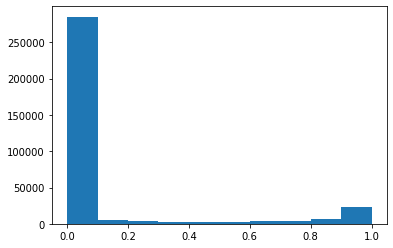

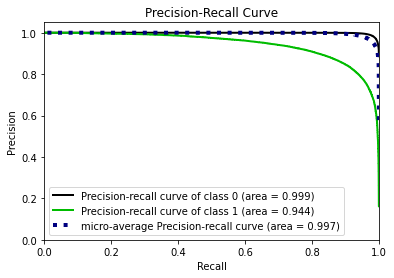

In [80]:
data_analysis.model_tuning()


独立测试数据集概率分布情况如下所示：
测试数据集行数为340043

根据PR曲线相应阈值一(0.404397)完成预测
总SNP数目为340043，其中通过模型判别为阳性的个案数目为42206，占比为1:8

根据PR曲线相应阈值二(0.439326)完成预测
总SNP数目为340043，其中通过模型判别为阳性的个案数目为41249，占比为1:8


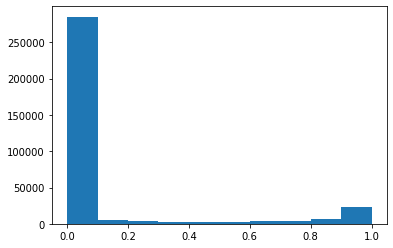

In [81]:
data_analysis.model_utilze()

In [108]:
test_flag = pd.Series(data_analysis.test_pred_PR_thre, name="flag")

In [114]:
result_df = pd.concat([pd.Series(data_analysis.test_info.index), test_flag], axis = 1)

In [115]:
result_df

,cust_id,flag
0,784001,1
1,784002,1
2,784003,0
3,784004,0
4,784005,0
...,...,...
340038,1124039,0
340039,1124040,1
340040,1124041,0
340041,1124042,0


In [120]:
# 模型预测值
result_df.to_csv("/home/lqh/projects/程浩/广东省农信联社2021年校园挑战赛-数据集与数据说明-第一赛道/数据集+数据说明/result.csv", index=False)

In [125]:
result_df['flag']

0         1
1         1
2         0
3         0
4         0
         ..
340038    0
340039    1
340040    0
340041    0
340042    0
Name: flag, Length: 340043, dtype: int64

In [122]:
# 真实值
test_label = pd.read_csv("/home/lqh/projects/程浩/广东省农信联社2021年校园挑战赛-数据集与数据说明-第一赛道/数据集+数据说明/test_label.csv")

In [123]:
test_label

,flag
0,1
1,1
2,0
3,0
4,0
...,...
340038,0
340039,1
340040,1
340041,0


In [124]:
print("Accuracy Score : (how much of variants type was predicted correctly) :",
    accuracy_score(test_label, result_df['flag']))  # 打印准确度
print("Recall Score (how much of TP were predicted correctly) : ",
    recall_score(test_label, result_df['flag']))  # 打印召回率
print("F1 Score (composite metric for precision and recall): ",
    f1_score(test_label, result_df['flag']))  # 打印精度
print("Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'): ",
    precision_score(test_label, result_df['flag']))  # 打印精度

Accuracy Score : (how much of variants type was predicted correctly) : 0.969224480433357
Recall Score (how much of TP were predicted correctly) :  0.8963364383287965
F1 Score (composite metric for precision and recall):  0.8727644105095502
Precision Score (how much of TPs, which were predicted as 'TP', were actually 'TP'):  0.8504004170023219
